In [6]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))



/Users/David/Programmiersachen/Uni/PhD-Applications/cispa-prep/code/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[init_weights] VAR with init_std=0.0180422
prepare finished.


In [7]:
from collections import defaultdict

def extract_var_activations(var_model, input_tokens, target_layers=None):
    """
    Extract activations from VAR model layers during forward pass
    
    Args:
        var_model: The loaded VAR model
        input_tokens: Input tokens for the model
        target_layers: List of layer names to extract (if None, extracts all FFN layers)
    
    Returns:
        Dictionary of layer_name -> activation tensor
    """
    activations = {}
    hooks = []
    
    if target_layers is None:
        # Extract all FFN layers by default
        target_layers = []
        for name, module in var_model.named_modules():
            if 'ffn.fc1' in name or 'ffn.fc2' in name or name == 'head':
                target_layers.append(name)
    
    def make_hook(layer_name):
        def hook_fn(module, input, output):
            # Store activation, handling different output shapes
            if isinstance(output, torch.Tensor):
                if len(output.shape) == 3:  # [batch, sequence, features]
                    # Average across sequence dimension for transformers
                    activations[layer_name] = output.mean(dim=1).detach()
                else:
                    activations[layer_name] = output.detach()
            else:
                # Handle tuple outputs (some layers return multiple values)
                activations[layer_name] = output[0].detach()
        return hook_fn
    
    # Register hooks
    for layer_name in target_layers:
        try:
            layer = dict(var_model.named_modules())[layer_name]
            hook = layer.register_forward_hook(make_hook(layer_name))
            hooks.append(hook)
        except KeyError:
            print(f"Warning: Layer {layer_name} not found")
    
    # Perform forward pass
    try:
        with torch.no_grad():
            _ = var_model(torch.tensor([1,]), input_tokens)
    finally:
        # Clean up hooks
        for hook in hooks:
            hook.remove()
    
    return activations


def extract_all_linear_activations(var_model, input_tokens):
    """
    Extract activations from all Linear (fully connected) layers in the VAR model.

    Args:
        var_model: The loaded VAR model
        input_tokens: Input tokens for the model

    Returns:
        Dictionary of layer_name -> activation tensor
    """
    activations = {}
    hooks = []

    # Find all Linear layers
    for name, module in var_model.named_modules():
        if isinstance(module, torch.nn.Linear):
            def make_hook(layer_name):
                def hook_fn(module, input, output):
                    if isinstance(output, torch.Tensor):
                        if len(output.shape) == 3:
                            activations[layer_name] = output.mean(dim=1).detach()
                        else:
                            activations[layer_name] = output.detach()
                    else:
                        activations[layer_name] = output[0].detach()
                return hook_fn
            hook = module.register_forward_hook(make_hook(name))
            hooks.append(hook)

    try:
        with torch.no_grad():
            _ = var_model(torch.tensor([1,]), input_tokens)
    finally:
        for hook in hooks:
            hook.remove()

    return activations

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# Create dataset
dataset = datasets.ImageFolder(
    root='./data/SomeClasses/',
    transform=transform
)
# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

In [11]:
from collections import defaultdict

selected_images_per_class = defaultdict(list)
num_select = 20

for img, label in dataloader:
    if len(selected_images_per_class[label.item()]) < num_select:
        selected_images_per_class[label.item()].append(img)
    # Stop if all classes have enough images
    if all(len(imgs) >= num_select for imgs in selected_images_per_class.values()):
        break

# selected_images_per_class: dict of class_label -> list of 5 images (each as a tensor)
print({k: len(v) for k, v in selected_images_per_class.items()})

{5: 20, 4: 20, 3: 20, 0: 20, 7: 20, 6: 20, 1: 20, 2: 20}


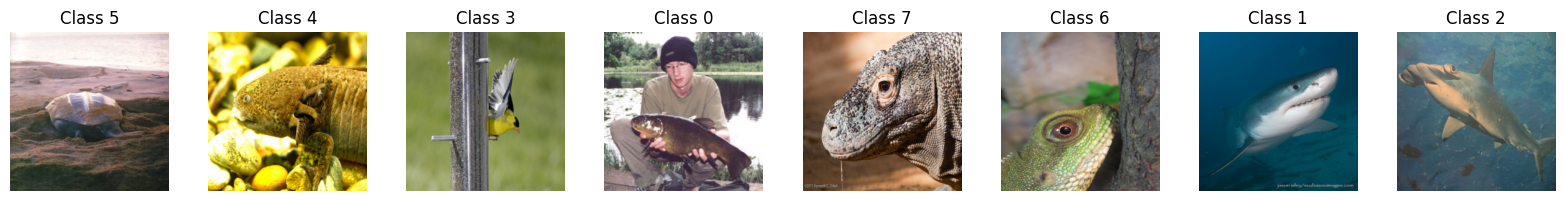

In [15]:
import matplotlib.pyplot as plt

# Use selected_images_per_class from cell 3
images_per_class = selected_images_per_class

n_classes = len(images_per_class)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes * 2, 2))

if n_classes == 1:
    axes = [axes]

for col, (label, imgs) in enumerate(images_per_class.items()):
    ax = axes[col]
    img = imgs[0]  # Display the first image for each class
    img_disp = img.squeeze(0) if img.dim() == 4 else img
    ax.imshow(img_disp.permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
    ax.set_title(f"Class {label}")

plt.tight_layout()
plt.show()

## Iterate over different images and collect activations

In [10]:
nsamples = 12
all_means = []
for i, image in enumerate(dataloader): 
    print(i)
    if i >= nsamples:
        break
    image = image[0]
    print(image.shape)
    image = image.to(device)
    this_imgs_activations = []
    for _ in range(10):  # Iterate over different random augmentations
        image = Aug(image)  # Apply random augmentation
        with torch.no_grad():
            # This depends on your VAE implementation
            # You may need to adjust based on your specific VAE interface
            #encoded_tokens = vae.encode(image_tensor)  # Adjust this line
            vae_out = vae.img_to_idxBl(image)
            var_in = var.vae_quant_proxy[0].idxBl_to_var_input(vae_out)    
        activations = extract_all_linear_activations(var, var_in)
        this_imgs_activations.append(activations)
    # Compute the mean activation across all augmentations for each layer in all_activations
    layer_means = {}
    if this_imgs_activations:
        # Get all layer names from the first activation dict
        layer_names = this_imgs_activations[0].keys()
        for lname in layer_names:
            # Stack tensors for this layer across all augmentations
            stacked = torch.stack([a[lname] for a in this_imgs_activations], dim=0)
            # Compute mean across augmentations (dim=0)
            layer_means[lname] = stacked.mean(dim=0)
            #print(f"Layer: {lname}, Mean activation shape: {layer_means[lname].shape}")
    all_means.append(layer_means)

0
torch.Size([1, 3, 256, 256])


NameError: name 'Aug' is not defined

## Data analysis part

#### Compute the max activation across all units for each layer

In [ ]:
# For each layer, stack all mean activations across images and compute the maximum per unit
max_per_unit_all_layers = {}

# Assume all_means is a list of dicts, each dict: layer_name -> mean activation tensor
if all_means:
    layer_names = all_means[0].keys()
    for lname in layer_names:
        # Stack all mean activations for this layer across images
        stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0)
        # Compute the maximum for each unit across all images (dim=0)
        max_per_unit_all_layers[lname] = stacked_means.max(dim=0).values
        print(f"Maximum per unit in layer {lname}:")
        print(max_per_unit_all_layers[lname])

#### compute max and argmax for each layer

In [5]:
#For each layer, stack all mean activations across images and compute the maximum and argmax per unit
max_per_unit_all_layers = {}
argmax_per_unit_all_layers = {}

if all_means:
    layer_names = all_means[0].keys()
    for lname in layer_names:
        # Stack all mean activations for this layer across images
        stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0)
        # Compute the maximum and argmax for each unit across all images (dim=0)
        stacked_means = stacked_means.abs()
        max_per_unit_all_layers[lname] = stacked_means.max(dim=0).values
        argmax_per_unit_all_layers[lname] = stacked_means.argmax(dim=0)
        print(f"Layer: {lname}")
        print(f"Maximum per unit: {max_per_unit_all_layers[lname]}")
        print(f"Argmax per unit: {argmax_per_unit_all_layers[lname]}")

#### compute $\mu_{-max}$, i.e. the nominator of the unit mem metric

In [ ]:
# For each layer, compute the mean activation across all images except the one at argmax for each unit
mean_minus_max_per_unit_all_layers = {}

if all_means:
    layer_names = all_means[0].keys()
    n_imgs = len(all_means)
    for lname in layer_names:
        # Stack all mean activations for this layer across images: shape [n_imgs, 1, n_units]
        stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0)
        # Find argmax index for each unit
        stacked_means = stacked_means.abs()
        argmax_idx = stacked_means.argmax(dim=0)  # shape [1, n_units]
        # For each unit, exclude the image at argmax and compute mean over the rest
        means = []
        for unit in range(stacked_means.shape[2]):
            # Get indices of all images except the one at argmax for this unit
            mask = torch.ones(n_imgs, dtype=torch.bool)
            mask[argmax_idx[0, unit]] = False
            # Compute mean over the remaining images for this unit
            mean_val = stacked_means[mask, 0, unit].mean()
            means.append(mean_val)
        mean_minus_max_per_unit_all_layers[lname] = torch.stack(means)
        print(f"Layer: {lname}, µ-max per unit shape: {mean_minus_max_per_unit_all_layers[lname]}")

#### compute difference

In [6]:
# Compute the difference between max_per_unit_all_layers and mean_minus_max_per_unit_all_layers for each layer
diff_max_minus_mean_all_layers = {}

for lname in max_per_unit_all_layers.keys():
    diff_max_minus_mean_all_layers[lname] = max_per_unit_all_layers[lname] - mean_minus_max_per_unit_all_layers[lname]
    print(f"Layer: {lname}, Difference shape: {diff_max_minus_mean_all_layers[lname].shape}")
    print(diff_max_minus_mean_all_layers[lname])

#### compute unit mem metric

In [ ]:
# Compute the normalized difference: (max - mean) / (max + mean) for each layer
normalized_diff_all_layers = {}

for lname in diff_max_minus_mean_all_layers.keys():
    max_vals = max_per_unit_all_layers[lname]
    mean_vals = mean_minus_max_per_unit_all_layers[lname]
    denom = max_vals + mean_vals
    # Avoid division by zero
    normalized_diff = diff_max_minus_mean_all_layers[lname] / (denom + 1e-8)
    normalized_diff_all_layers[lname] = normalized_diff
    print(f"Layer: {lname}, Normalized difference shape: {normalized_diff.shape}")
    print(normalized_diff)